# Apply Keras Networks to V1 Data

**Ted Moskovitz, 2018**

load dependencies, set display parameters

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path
from time import time
import nonlinearity as nl

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU, CuDNNLSTM, Flatten, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Input
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, TensorBoard
import time 

from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color, get_nn_model
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model, gen_ES_model

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 18

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

**Standard DNN Models**

In [6]:
ln_fs = [0,1,2,3,4,5]

h_layers_fc = [2]#,1,2,3]
h_sizes_fc = [64]#,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

# dictionary of hyperparameters
hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)}}

training pipeline

In [ ]:
# model settings
celltype = 'simple'
model_type = 'cnn'
plot = False 
gen_psth = False
save_model = False
save_perf = False 
restore_frm_chkpt = False
v1 = V1(celltype, 1)
save_best = False

ndepths = hparams[model_type]['ndepths']
nwidths = hparams[model_type]['nwidths']
nfilts = len(ln_fs)

performance_bps = np.zeros([ndepths, nwidths, cell_nums[celltype]])
performance_r2 = np.zeros([ndepths, nwidths, cell_nums[celltype]])
filter_bps = np.zeros([nfilts])
filter_r2 = np.zeros([nfilts])
best_r2 = -1.
best_bps = -1.

# can choose to restore performance checkpoint
if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    performance_bps = restore_performance_checkpt('./SavedResults/' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    performance_bps = performance_bps.reshape(ndepths, nwidths, cell_nums[celltype])
    best_bps = np.max(performance_bps)
    
    performance_r2 = restore_performance_checkpt('./SavedResults/' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    performance_r2 = performance_r2.reshape(ndepths, nwidths, cell_nums[celltype])
    best_r2 = np.max(performance_r2)
    

# define early stopping callback - UNUSED currently
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;
    
perfs = np.zeros(cell_nums[celltype])


k = 0
for cell_num in range(1):#,cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten);
    i = 0
    for L in [2]:#hparams[model_type]['h_layers']:
        j = 0
        for H in [64]:#hparams[model_type]['h_sizes']:
            if performance_bps[i,j,k] == 0.: # avoid redundancy
                print ("============================================================")
                print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L+2) + " and width of " + str(H) + color.END) 
                # generate model
                model = gen_model[model_type](H, L=L, dim=v1.X_train.shape[-1])
                #model = get_nn_model(celltype, model_type, metric='r2', filts=False)

                # fit model
                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=16, 
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) #22 for comp
                time.sleep(0.1)

                # evaluate performance
                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))
                
                perfs[cell_num] = rsq

                if bps > best_bps and save_model:
                    best_bps = bps
                    print (color.PURPLE + 'saving new bps model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_bps.h5')

                if (rsq > best_r2 and save_model) or save_best:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/32f_' + celltype + '_best_' + model_type + '_r2_cell'
                               + str(cell_num+1)+'.h5')

                performance_bps[i,j,k] = bps
                performance_r2[i,j,k] = rsq

                # generate a PSTH using the current cell's repeat data, if desired
                if gen_psth:
                    rpt_preds = model.predict(v1.X_rpt)
                    model_psth = v1.convert_nn_psth(rpt_preds)

                    if plot:
                        plt.plot(model_psth, label='nn')
                        plt.plot(v1.psth, label='repeat')
                        plt.legend()
                        plt.xlabel('Time (ms)')
                        plt.ylabel('Rate (sp/s)')
                        plt.show()


                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


            j += 1
            
            if save_perf: 
                print (color.BOLD + 'saving checkpoint...\n' + color.END)
                np.savetxt('./SavedResults/' + celltype + '_' + model_type \
                           + '_bps.csv', performance_bps.reshape(-1,1), delimiter=',')
                np.savetxt('./SavedResults/' + celltype + '_' + model_type \
                           + '_r2.csv', performance_r2.reshape(-1,1), delimiter=',')
        i += 1
    k += 1


building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
Training Model on Cell 1 of 3 with depth of 4 and width of 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 16, 64)            7232      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 64)             20544     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 8, 64)          

In [35]:
model.save('SavedModels/' + celltype + '_best_' + model_type + '_r2_cell1.h5')

**pca reconstruction experiment**

In [2]:
def get_nn_wts(model, celltype, metric='r2', verbose=False, filts=False):
    nn = get_nn_model(celltype, model, metric=metric, verbose=verbose, filts=filts) 
    if verbose: nn.summary(); 
    weights = [l.get_weights() for l in nn.layers]
    return weights

def get_filts(wts):
    return wts[0][0]

def pca_reconstruct(filts, i):
    n = filts.shape[1]
    X = filts#.reshape(-1,128)
    mu = np.mean(X, axis = 0)
    X_c = X - mu # zero-center the data (important)
    cov = np.dot(X_c.T, X_c) / X.shape[0] # get the data covariance matrix
    U,S,V = np.linalg.svd(cov)
    #Xrot = np.dot(X, U) # decorrelate the data
    Ured = U[:,:i] if i < n else U
    Xrot_red = np.dot(X_c, Ured) # Xrot_reduced becomes [N x i]
    X_rec = np.dot(Ured, Xrot_red.T) + mu.reshape(X.shape[1],1)
    return X_rec.T

def get_upper_wts(wts):
    # extract upper layer weights
    ws = {}
    bs = {}
    lc = 1
    for l in range(len(wts)):
        if len(wts[l]) > 0:
            ws[lc] = wts[l][0]
            bs[lc] = wts[l][1]
            lc += 1
    return ws, bs

In [4]:
mod = get_nn_model('simple', 'cnn', metric='r2', verbose=True, filts=False)
mod.summary()

loading cnn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 16, 64)            7232      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 4, 64)             0     

In [5]:
celltype = 'simple'
model_type = 'fc'
n_filts = {'simple':64, 'complex':128}
perfs = np.zeros([cell_nums[celltype], n_filts[celltype]])
metric='r2'
save_perf = False
p_bps = []

for c in range(1,2):#cell_nums[celltype]+1):
    print ('===============================')
    print ('Working on Cell {} of {}'.format(c,cell_nums[celltype]))
    v1 = V1(celltype, c, flatten=True)
    mm = get_nn_model(celltype, model_type, metric=metric, verbose=True, filts=False, cell=c) 
    K,b = mm.layers[0].get_weights()

    for i in range(1,n_filts[celltype]+1):
        # reconstruct filters using principle components
        K_red = pca_reconstruct(K, i)
        # insert reconstructed filters into model
        mm.layers[0].set_weights(weights=[K_red, b])

        # test it
        bps,_ = get_bps(mm, v1)
        _, rsq = r2(mm.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))
        
        perfs[c-1,i-1] = rsq
        p_bps.append(bps)

        print ("{}/{} reconstructed filter(s): r^2 = {}, I_ss = {}".format(i,n_filts[celltype],rsq,bps))
    

if save_perf:
    path = './SavedResults/{}_{}_pca.csv'.format(celltype, model_type)
    np.savetxt(path, perfs, delimiter=',')


Working on Cell 1 of 3
building data...
fetching repeat data...
done.
1/32 reconstructed filter(s): r^2 = 0.2849132257355568, I_ss = 0.8225247126412597
2/32 reconstructed filter(s): r^2 = 0.2854907880715246, I_ss = 0.8239919317227062
3/32 reconstructed filter(s): r^2 = 0.28564387200043023, I_ss = 0.8242070228423907
4/32 reconstructed filter(s): r^2 = 0.28779788266545603, I_ss = 0.8288142947980102
5/32 reconstructed filter(s): r^2 = 0.2878723672722287, I_ss = 0.8297745734147318
6/32 reconstructed filter(s): r^2 = 0.2881129225494427, I_ss = 0.8312370797884323
7/32 reconstructed filter(s): r^2 = 0.2881340337242016, I_ss = 0.831767786596064
8/32 reconstructed filter(s): r^2 = 0.2883284755195921, I_ss = 0.8322391793007645
9/32 reconstructed filter(s): r^2 = 0.2884753141371591, I_ss = 0.8332779119590065
10/32 reconstructed filter(s): r^2 = 0.288789967683164, I_ss = 0.8343497701740513
11/32 reconstructed filter(s): r^2 = 0.28900134995756255, I_ss = 0.8353983351262138
12/32 reconstructed filte

In [7]:
path = './SavedResults/{}_{}_pca.csv'.format(celltype, model_type)
np.savetxt(path, perfs, delimiter=',')

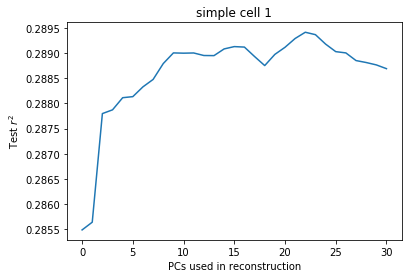

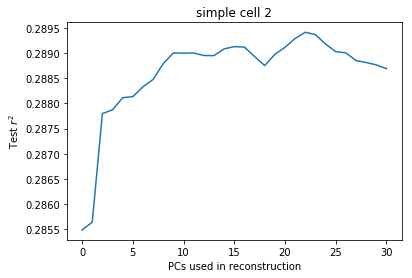

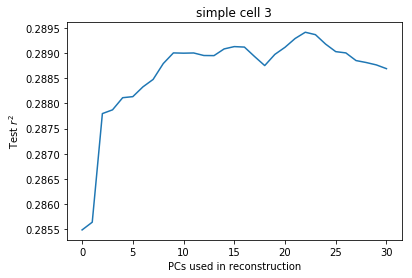

In [6]:
celltype = 'simple'
path = './SavedResults/{}_{}_pca.csv'.format(celltype, model_type)
p = np.genfromtxt(path, delimiter=',')
for i in range(1,cell_nums[celltype]+1):
    plt.plot(perfs[0,1:])
    plt.xlabel('PCs used in reconstruction')
    plt.ylabel('Test $r^2$')
    plt.title('{} cell {}'.format(celltype, i))
    plt.show()

In [42]:
celltype = 'complex'
m = get_nn_model(celltype, 'fc', metric='r2', verbose=True, filts=False)
m.summary()

loading fc...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_350 (Dense)            (None, 128)               32896     
_________________________________________________________________
activation_252 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 129       
Total params: 33,025
Trainable params: 33,025
Non-trainable params: 0
_________________________________________________________________


In [171]:
print (np.sqrt(np.sum((filts-m.layers[0].get_weights()[0])**2)))

0.0


In [177]:
filts = m.layers[0].get_weights()[0]

In [178]:
fs = m.layers[0].get_weights()
m.layers[0].set_weights(weights=[filts, fs[1]])

In [17]:
m.summary()

_, rsq = r2(m.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [18]:
rsq

0.0078475506570980531

**DNN-LNP Hybrid Architecture**

hyperparameter settings

In [10]:
#ln_fs = [2,4,8,12,16,24]
#ln_fs = [1,2,4,8,16,32]
ln_fs = [32] #1,2,3,4,5,6,

#s_fc_config = {'L':2, 'H':50}
s_fc_config = {'L':1, 'H':64}
s_rnn_config = {'L':2, 'H':50}
s_cnn_config = {'L':0, 'H':64}

c_fc_config = {'L':2, 'H':128}
c_rnn_config = {'L':2, 'H':25}
c_cnn_config = {'L':1, 'H':32}


params = {'fc':{'simple':s_fc_config, 'complex':c_fc_config},
          'rnn':{'simple':s_rnn_config, 'complex':c_rnn_config},
          'cnn':{'simple':s_cnn_config, 'complex':c_cnn_config}}

training pipeline

In [11]:
celltype = 'complex'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = False
save_perf = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)

nfilts = len(ln_fs)
use_filts = False
trainable = True # freeze/un-freeze pre-trained filters


pf_bps = np.zeros([nfilts, cell_nums[celltype]])
pf_r2 = np.zeros([nfilts, cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.


# for saving
prefix = ''
if use_filts: prefix += 'istac_';
else: prefix += 'filts_'
if trainable: prefix += 'tr_';
    
print (prefix)


if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/' + prefix + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(-1, cell_nums[celltype])
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/' + prefix + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(-1, cell_nums[celltype])
    best_r2 = np.max(pf_r2)
    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;

H = params[model_type][celltype]['H']
L = params[model_type][celltype]['L']

cell_r2s = []



j = 0
for cell_num in [3]:#range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten);
    filters = None if not use_filts else np.genfromtxt('./SavedFilters/'+celltype+'_istac_filters_cell'+str(cell_num+1)+'.csv',
                                                       delimiter=',')
    i = 0
    #best_r2 = -1.
    for nf in ln_fs:
        if pf_bps[i,j] == 0.:
            print ("============================================================")
            print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                   + " with " + str(nf) + " Filter(s)" + color.END) 
            
            # if initializing with pre-trained/calculated filters (i.e. iSTAC)
            if filters is not None: filts = filters[:,:nf];
            else: filts = None;
            model = gen_model[model_type](H, L=L, LNP=nf, dim=v1.X_train.shape[-1], filts=filts, trainable=trainable)

            hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=20,
                             verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
            time.sleep(0.1)

            # evaluate performance metrics
            bps,_ = get_bps(model, v1)
            _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))
            
            # save best-performing model
            if bps > best_bps and save_model:
                best_bps = bps
                print (color.PURPLE + 'saving new bps model...' + color.END)
                model.save('SavedModels/' + prefix + celltype + '_best_' + model_type + '_bps.h5') 

            if rsq > best_r2 and save_model:
                best_r2 = rsq
                print (color.PURPLE + 'saving new r2 model...' + color.END)
                model.save('SavedModels/' + prefix + celltype + '_best_' + model_type + '_r2.h5')

            pf_bps[i,j] = bps
            pf_r2[i,j] = rsq

            if gen_psth:
                rpt_preds = model.predict(v1.X_rpt)
                model_psth = v1.convert_nn_psth(rpt_preds)

                if plot:
                    plt.plot(model_psth, label='nn')
                    plt.plot(v1.psth, label='repeat')
                    plt.legend()
                    plt.xlabel('Time (ms)')
                    plt.ylabel('Rate (sp/s)')
                    plt.show()


            print ("bps: ", bps)
            print ("r2: ", rsq)
            print (" ")


        i += 1

        if save_perf:
            print (color.BOLD + 'saving performance checkpoint...\n' + color.END)
            np.savetxt('./SavedResults/' + prefix + celltype + '_' + model_type \
                       + '_bps.csv', pf_bps.reshape(-1,1), delimiter=',')
            np.savetxt('./SavedResults/' + prefix + celltype + '_' + model_type \
                       + '_r2.csv', pf_r2.reshape(-1,1), delimiter=',')

    j += 1
    cell_r2s.append(best_r2)
    

building data...
fetching repeat data...
done.
filts_tr_
building data...
fetching repeat data...
done.
Training Model on Cell 4 of 9 with 32 Filter(s)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0

In [6]:
.024

0.2895

In [20]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

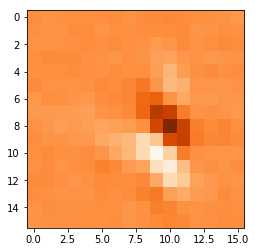

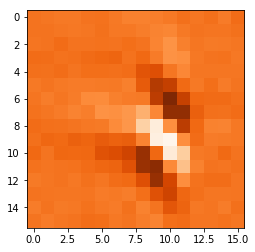

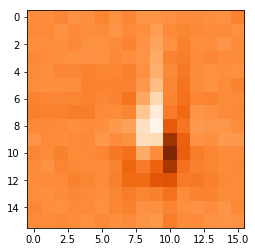

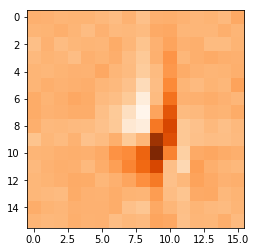

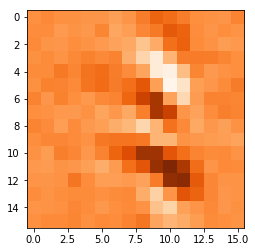

In [21]:
for i in range(5):
    w = weights[0][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Oranges')
    plt.show()

comparison of convergence rates

In [42]:
np.savetxt('./SavedResults/simple_fc_bps_loss.csv', hist.history['loss'], delimiter=',')

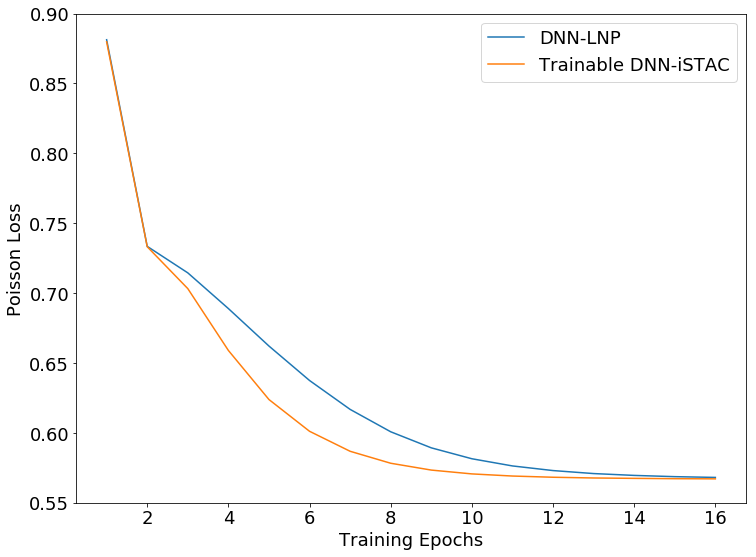

In [11]:
h1 = np.genfromtxt('./SavedResults/filts_simple_fc_bps_loss.csv', delimiter=',')
h2 = np.genfromtxt('./SavedResults/istac_tr_simple_fc_bps_loss.csv', delimiter=',')
h3 = np.genfromtxt('./SavedResults/simple_fc_bps_loss.csv', delimiter=',')
n_epochs = len(h1)
epochs = np.arange(n_epochs) + 1
plt.plot(epochs, h1, label='DNN-LNP')
plt.plot(epochs, h2, label='Trainable DNN-iSTAC')
#plt.plot(h3, label='DNN')
plt.legend()
plt.ylim([0.55, 0.9])
plt.xlabel('Training Epochs')
plt.ylabel('Poisson Loss')
plt.show()

In [54]:
weights = [l.get_weights() for l in model.layers]

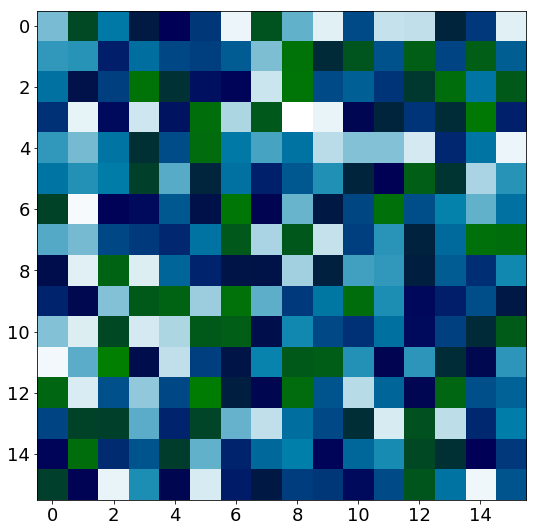

IndexError: index 1 is out of bounds for axis 1 with size 1

In [55]:
weights = [l.get_weights() for l in model.layers]
for i in range(4):
    plt.imshow(weights[0][0][:,i].reshape(-1,16), interpolation='nearest', cmap='ocean')
    plt.show()

In [4]:
x,y,z = nl.generate(model)

18000 / 90000 points computed
36000 / 90000 points computed
54000 / 90000 points computed
72000 / 90000 points computed


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


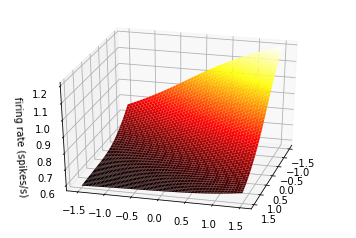

In [7]:
#from comp_nlin import comp_nlin2D
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as spsig
import scipy.ndimage as spnd
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, cmap='hot', alpha=1.0) #, label='NN'

#plt.show()

# rotate the axes and update
for angle in [15]:#range(0, 360):
    ax.view_init(30, angle)
    #ax.set_zlabel('firing rate (sp/s)')
    plt.draw()
    plt.pause(.001)

ax.legend()
ax.set_zlabel('firing rate (spikes/s)')
plt.show()



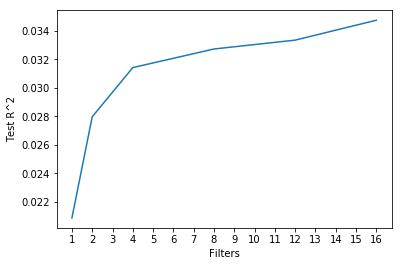

In [9]:
plt.plot(ln_fs, np.mean(pf_r2, axis=1))
plt.xlabel('Filters')
plt.ylabel('Test R^2')
plt.xticks(np.asarray(range(max(ln_fs)))+1)
plt.show()

In [188]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
    
print len(weights)

5


In [3]:
cell = 'simple'
model = 'cnn'
metric = 'r2'

model = get_nn_model(cell, model, metric=metric, filts=False)
model.summary()

loading cnn...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_183 (Conv1D)          (None, 16, 64)            7232      
_________________________________________________________________
conv1d_184 (Conv1D)          (None, 16, 64)            28736     
_________________________________________________________________
max_pooling1d_82 (MaxPooling (None, 8, 64)             0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 8, 64)             0         
_________________________________________________________________
conv1d_185 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
conv1d_186 (Conv1D)          (None, 8, 64)             20544     
_________________________________________________________________
max_pooling1d_83 (MaxPooling (None, 4, 64)             0     

In [7]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

In [8]:
len(weights[0])

2

In [9]:
weights[0][1].shape

(5,)

In [11]:
mod = load_model('SavedModels/es_tr_simple_best_fc_r2.h5', custom_objects={'poiss_full': poiss_full})

In [12]:
mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_filter (Dense)              (None, 3)            771         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_filter (Dense)              (None, 2)            514         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_wts (Dense)          (None, 3)            12          exc_filter[0][0]                 
__________________________________________________________________________________________________
suppressiv

In [14]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

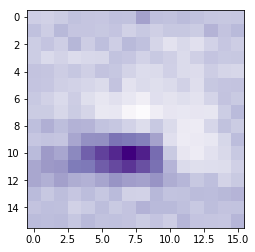

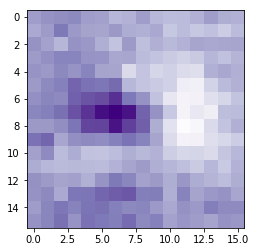

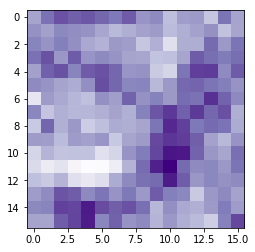

In [18]:
for i in range(3):
    w = weights[1][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Purples')
    plt.show()

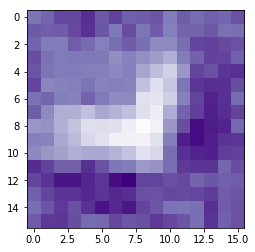

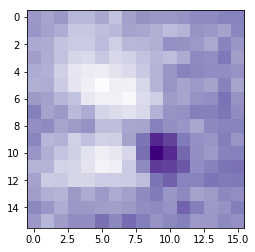

In [19]:
for i in range(2):
    w = weights[2][0][:,i].reshape(16,16)
    w /= np.linalg.norm(w)
    plt.imshow(w, interpolation='nearest', cmap='Purples')
    plt.show()

In [10]:
def normalize(f):
    mu = np.mean(f)
    var = np.var(f)
    eps = 1e-7
    return (f - mu) / np.sqrt(var + eps)

In [15]:
for i in range(5):
    filt = weights[0][0][:,i]
    print (np.max(weights[0][0][:,i]))
    print (np.min(weights[0][0][:,i]))
    if np.abs(np.max(filt)) >= np.abs(np.min(filt)): print ('Excitatory:');
    else: print ('Inhibitory:')
    w = weights[0][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='bone')
    #plt.imshow(normalize(filt).reshape(16,16), interpolation='nearest', cmap='hot')
    plt.colorbar()
    plt.show()

IndexError: list index out of range

In [4]:
E = np.hstack([weights[0][0][:,i].reshape(-1,1) for i in [0,1,3]])
print (E.shape)
S = np.hstack([weights[0][0][:,i].reshape(-1,1) for i in [2,4]])
H = 32

(256, 3)


In [5]:
es_model = gen_ES_model(E, S, H, dim=256, L=2, verbose=True)

In [6]:
es_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_linear (Dense)              (None, 3)            771         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_linear (Dense)              (None, 2)            514         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_filt (Dense)         (None, 3)            12          exc_linear[0][0]                 
__________________________________________________________________________________________________
suppressiv

**Excitatory-Suppressive Model** 

(inspired by Rust et al. '05)

In [20]:
def get_E_and_S(model, n_filts):
    """
    Extract excitatory and suppressive filters from a given model. 
    
    Args: 
        model: a trained Keras model
        
    Returns: 
        E: stacked excitatory filters (numpy ndarray)
        S: stacked suppressive filters (numpy ndarray)
    """
    weights = []
    for layer in model.layers:
        weights.append(layer.get_weights())
        
    filters = weights[0][0]
    filters = filters[:,:n_filts]
    
    # heuristic to ID E and S: E if max value > min, S if min > max
    Es = []
    Ss = []
    for i in range(filters.shape[1]):
        filt = filters[:,i]
        if np.abs(np.max(filt)) >= np.abs(np.min(filt)): Es.append(i);
        else: Ss.append(i);
    
    # if model lacks excitatory and/or suppressive filters
    if len(Es) > 0: E = np.hstack([filters[:,i].reshape(-1,1) for i in Es]);
    else: E = np.random.randn(filters.shape[0]).reshape(-1,1)
    if len(Ss) > 0: S = np.hstack([filters[:,i].reshape(-1,1) for i in Ss]);
    else: S = np.random.randn(filters.shape[0]).reshape(-1,1)
    
    return E,S

training pipeline

In [12]:
celltype = 'simple'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = True
save_perf = True
restore_frm_chkpt = False
v1 = V1(celltype, 1)
use_istac = False

Ls = [0,1,2,3]
Hs = [16,32,96,128]
filters = [2,3,4,5,6,7]

pf_bps = np.zeros([len(Ls), len(Hs), cell_nums[celltype]])
pf_r2 = np.zeros([len(Ls), len(Hs), cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(len(Ls), len(Hs), -1)
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(len(Ls), len(Hs), -1)
    best_r2 = np.max(pf_r2)
    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;

k = 0
for cell_num in range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten)
    
    
    
    for nf in 
    if use_istac:
        pass
    else:
        # load model from which filters will be pulled
        filt_model = get_nn_model(celltype, model_type, metric='r2', filts=True, cell=cell_num+1)
        # extract filters
        E,S = get_E_and_S(filt_model, nf)
    
    if E is not None:
        i = 0
        for L in Ls:
            j = 0
            for H in Hs:
                if pf_bps[i,j,k] == 0.:
                    print ("============================================================")
                    print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                           + " with depth of " + str(L) + " and width of " + str(H) + color.END) 
                    
                    # load model
                    model = gen_ES_model(E, S, H, dim=v1.X_train.shape[-1], L=L, verbose=True, trainable=True) 
                    
                    # fit model
                    hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=10+L*4,
                                     verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                    time.sleep(0.1)

                    # evaluate performance metrics
                    bps,_ = get_bps(model, v1)
                    _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                    if bps > best_bps and save_model:
                        best_bps = bps
                        print (color.PURPLE + 'saving new bps model...' + color.END)
                        model.save('SavedModels/es_tr_' + celltype + '_best_' + model_type + '_bps.h5')

                    if rsq > best_r2 and save_model:
                        best_r2 = rsq
                        print (color.PURPLE + 'saving new r2 model...' + color.END)
                        model.save('SavedModels/es_tr_' + celltype + '_best_' + model_type + '_r2.h5')

                    pf_bps[i,j,k] = bps
                    pf_r2[i,j,k] = rsq

                    if gen_psth:
                        rpt_preds = model.predict(v1.X_rpt)
                        model_psth = v1.convert_nn_psth(rpt_preds)

                        if plot:
                            plt.plot(model_psth, label='nn')
                            plt.plot(v1.psth, label='repeat')
                            plt.legend()
                            plt.xlabel('Time (ms)')
                            plt.ylabel('Rate (sp/s)')
                            plt.show()


                    print ("bps: ", bps)
                    print ("r2: ", rsq)
                    print (" ")


                j += 1

                if save_perf: 
                    print (color.BOLD + 'saving checkpoint...\n' + color.END)
                    np.savetxt('./SavedResults/es_tr_' + celltype + '_' + model_type \
                               + '_bps.csv', pf_bps.reshape(-1,1), delimiter=',')
                    np.savetxt('./SavedResults/es_tr_' + celltype + '_' + model_type \
                               + '_r2.csv', pf_r2.reshape(-1,1), delimiter=',')
            i += 1
        k += 1



building data...
fetching repeat data...
done.
loading checkpoint...
building data...
fetching repeat data...
done.
loading fc...
saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

saving checkpoint...

building data...
fetching repeat data...
done.
loading fc...
building data...
fetching repeat data...
done.
loading fc...
Training Model on Cell 3 of 3 with depth of 0 and width of 16
Train on 68801 samples, validate on 9828 samples
Epoch 1/10
68801/68801 [==============================] - 4s 51us/step - loss: 0.8051 - val_loss: 0.7730
Epoch 2/10
68801/68801 [==============================] - 2s 30us/step - loss: 0.7259 - val_loss: 0.7196
Epoch 3/10
68801/68801 [==============================] - 2s 29us/step - lo

68801/68801 [==============================] - 3s 40us/step - loss: 0.6396 - val_loss: 0.6485
Epoch 5/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6326 - val_loss: 0.6428
Epoch 6/14
68801/68801 [==============================] - 3s 44us/step - loss: 0.6266 - val_loss: 0.6378
Epoch 7/14
68801/68801 [==============================] - 3s 43us/step - loss: 0.6217 - val_loss: 0.6335
Epoch 8/14
68801/68801 [==============================] - 3s 40us/step - loss: 0.6178 - val_loss: 0.6303
Epoch 9/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6145 - val_loss: 0.6273
Epoch 10/14
68801/68801 [==============================] - 3s 39us/step - loss: 0.6121 - val_loss: 0.6252
Epoch 11/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6101 - val_loss: 0.6234
Epoch 12/14
68801/68801 [==============================] - 3s 42us/step - loss: 0.6087 - val_loss: 0.6225
Epoch 13/14
68801/68801 [==============================] - 3s 4

68801/68801 [==============================] - 3s 38us/step - loss: 0.6422 - val_loss: 0.6522
Epoch 5/22
68801/68801 [==============================] - 3s 40us/step - loss: 0.6365 - val_loss: 0.6465
Epoch 6/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6311 - val_loss: 0.6419
Epoch 7/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6262 - val_loss: 0.6377
Epoch 8/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6218 - val_loss: 0.6334
Epoch 9/22
68801/68801 [==============================] - 3s 39us/step - loss: 0.6178 - val_loss: 0.6315
Epoch 10/22
68801/68801 [==============================] - 3s 40us/step - loss: 0.6142 - val_loss: 0.6281
Epoch 11/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6115 - val_loss: 0.6253
Epoch 12/22
68801/68801 [==============================] - 3s 38us/step - loss: 0.6093 - val_loss: 0.6232
Epoch 13/22
68801/68801 [==============================] - 3s 3

In [12]:
def get_E_and_S_filt(filters):
    """
    Extract excitatory and suppressive filters from a given model. 
    
    Args: 
        filts: filters
        
    Returns: 
        E: stacked excitatory filters (numpy ndarray)
        S: stacked suppressive filters (numpy ndarray)
    """
    # heuristic to ID E and S: E if max value > min, S if min > max
    Es = []
    Ss = []
    for i in range(filters.shape[1]):
        filt = filters[:,i]
        if np.abs(np.max(filt)) >= np.abs(np.min(filt)): Es.append(i);
        else: Ss.append(i);
    
    # if model lacks excitatory and/or suppressive filters
    if len(Es) > 0: E = np.hstack([filters[:,i].reshape(-1,1) for i in Es]);
    else: E = np.random.randn(filters.shape[0]).reshape(-1,1)
    if len(Ss) > 0: S = np.hstack([filters[:,i].reshape(-1,1) for i in Ss]);
    else: S = np.random.randn(filters.shape[0]).reshape(-1,1)
    
    return E,S

In [16]:
celltype = 'complex'
model_type = 'fc'
plot = False 
gen_psth = False
save_model = True
save_perf = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)
use_istac = True

Ls = [3]
Hs = [32]
filters = [2]
n_filts = len(filters)

pf_bps = np.zeros([len(filters), cell_nums[celltype]])
pf_r2 = np.zeros([len(filters), cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(n_filts, -1)
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/es_tr_' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(n_filts, -1)
    best_r2 = np.max(pf_r2)
    

# data format
flatten = True

j = 0
i = 0
for cell_num in [0]:#range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten)
    i = 0
    for nf in filters:
        #if pf_bps[i,j] == 0.0:
        
        # get iSTAC filters
        filts = np.genfromtxt('SavedFilters/'+ celltype+'_istac_filters_cell'+str(cell_num+1)+'.csv', delimiter=',')
        filts = filts[:,:nf]
        E,S = get_E_and_S_filt(filts)

        best_filt_bps = -1
        best_filt_r2 = -1


        for L in Ls:
            for H in Hs:
                print ("============================================================")
                print (color.BOLD + "Training " + str(nf) + " Filter Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L) + " and width of " + str(H) + color.END) 

                # load model
                model = gen_ES_model(E, S, H, dim=v1.X_train.shape[-1], L=L, lr=0.00005,
                                     verbose=True, trainable=True) 

                # fit model
                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=20,
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                time.sleep(0.1)

                # evaluate performance metrics
                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                if bps > best_filt_bps: best_filt_bps = bps; 
                if rsq > best_filt_r2: best_filt_r2 = rsq; 

                if bps > best_bps and save_model:
                    best_bps = bps
                    print (color.PURPLE + 'saving new bps model...' + color.END)
                    model.save('SavedModels/2f_es_tr_' + celltype + '_best_' + model_type + '_bps.h5')

                if rsq > best_r2 and save_model:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/2f_es_tr_' + celltype + '_best_' + model_type + '_r2.h5')

                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


        pf_bps[i,j] = best_filt_bps
        pf_r2[i,j] = best_filt_r2
        if save_perf: 
            print (color.BOLD + 'saving checkpoint...\n' + color.END)
            np.savetxt('./SavedResults/2f_es_tr_' + celltype + '_' + model_type \
                       + '_bps.csv', pf_bps, delimiter=',')
            np.savetxt('./SavedResults/2f_es_tr_' + celltype + '_' + model_type \
                       + '_r2.csv', pf_r2, delimiter=',')
        i += 1
    print (pf_r2)
    j += 1




building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
Training 2 Filter Model on Cell 1 of 9 with depth of 3 and width of 32
Train on 229364 samples, validate on 32766 samples
Epoch 1/20
229364/229364 [==============================] - 13s 56us/step - loss: 1.1664 - val_loss: 1.1681
Epoch 2/20
229364/229364 [==============================] - 10s 44us/step - loss: 1.1661 - val_loss: 1.1678
Epoch 3/20
229364/229364 [==============================] - 8s 37us/step - loss: 1.1655 - val_loss: 1.1671
Epoch 4/20
229364/229364 [==============================] - 8s 37us/step - loss: 1.1631 - val_loss: 1.1632
Epoch 5/20
229364/229364 [==============================] - 8s 35us/step - loss: 1.1567 - val_loss: 1.1561
Epoch 6/20
229364/229364 [==============================] - 8s 35us/step - loss: 1.1491 - val_loss: 1.1509
Epoch 7/20
229364/229364 [==============================] - 8s 36us/step - loss: 1.1439 - val_loss: 1.1470
Epoch 8/20
229364/229364 [=======

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stim (InputLayer)         (None, 256)          0                                            
__________________________________________________________________________________________________
exc_filter (Dense)              (None, 1)            257         input_stim[0][0]                 
__________________________________________________________________________________________________
sup_filter (Dense)              (None, 1)            257         input_stim[0][0]                 
__________________________________________________________________________________________________
excitatory_wts (Dense)          (None, 1)            2           exc_filter[0][0]                 
__________________________________________________________________________________________________
suppressiv

In [13]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())

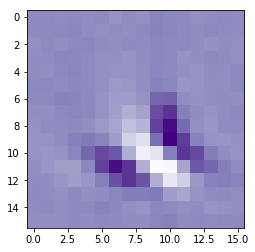

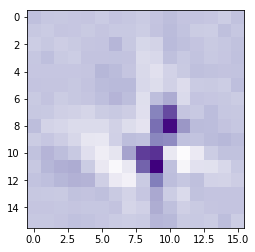

In [15]:
for i in range(2):
    w = weights[1][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='Purples')
    plt.show()

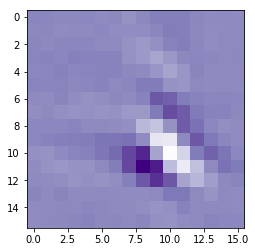

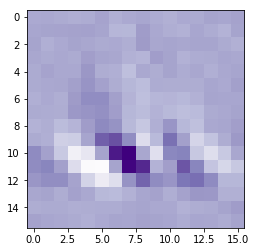

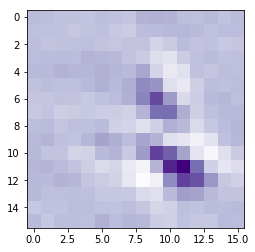

In [16]:
for i in range(3):
    w = weights[2][0][:,i].reshape(16,16)
    plt.imshow(w/np.linalg.norm(w), interpolation='nearest', cmap='Purples')
    plt.show()

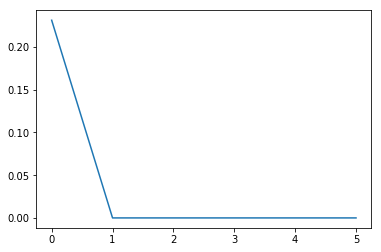

In [10]:
plt.plot(np.mean(pf_bps, axis=1))
plt.show()

In [21]:
np.where(pf_r2 == np.max(pf_r2))

(array([0]), array([3]))